### Plotting theta² 
binned in runs, or in nights.

In [7]:
import numpy as np
import pickle
import mysql.connector
import matplotlib.pyplot as plt
import pandas as pd
import pymysql
import os
from matplotlib.offsetbox import AnchoredText

In [8]:
# this is how we connect and put the mql command

def query(command):
    conn = mysql.connector.connect(user='xxxx',password='xxxxx',host='xxxx',database='xxxx',port='xxxx')
    cursor = conn.cursor()    
    result = pd.read_sql_query(command, conn)
    conn.close()
    return result

In [9]:
cmd = '''
SELECT
   Images.*,
   Position.X,
   Position.Y
FROM
   Images
LEFT JOIN Position USING (FileId, EvtNumber)
LEFT JOIN RunInfo  USING (FileId)
WHERE
   fSourceKey=7
AND
   fRunTypeKey=1
AND
   FileId BETWEEN 160601000 AND 160615000
AND
   fR750Cor>0.9*fR750Ref
AND
   NumUsedPixels>5.5
AND
   NumIslands<3.5
AND
   Leakage1<0.1
AND
   Width*Length*PI() < LOG10(Size)*898-1535
'''
data = query(cmd)

In [10]:
# here I'm saving how many runs we have in this period
unique_runs = np.unique(data['FileId'])
print(len(unique_runs))

547


In [11]:
data.columns

Index(['FileId', 'EvtNumber', 'Mjd', 'MilliSec', 'NanoSec', 'Length', 'Width',
       'Delta', 'Size', 'MeanX', 'MeanY', 'SinDelta', 'CosDelta', 'Asym',
       'M3Long', 'M3Trans', 'SlopeLong', 'SlopeTrans', 'TimeSpread',
       'TimeSpreadWeighted', 'SlopeSpread', 'SlopeSpreadWeighted',
       'NumIslands', 'SizeSubIslands', 'SizeMainIsland', 'Leakage1',
       'Leakage2', 'Conc', 'Conc1', 'ConcCOG', 'ConcCore', 'UsedArea',
       'CoreArea', 'NumUsedPixels', 'NumCorePixels', 'X', 'Y'],
      dtype='object')

In [12]:
# useful values
mm2deg = 0.0117193246260285378
# Create bins for the histogram
bins_number = 30
bins = np.linspace(0,0.3,bins_number+1)
# ratio between on and off regions
ratio_on_off = 1/5 

In [13]:
# transforming the column names into arrays with the name of the column and with its values
for par in list(data.columns):
    vars()[par] = data[f'{par}'].values

In [14]:
# First calculate all cuts to speed the analysis up
area =  np.pi*Width*Length
    
non = []
noff = []

# Loop over all wobble positions in the camera
for angle in range(0,360,60):

    # ----------- Source dependent parameter calculation ----------
    cr = np.cos(np.deg2rad(angle))
    sr = np.sin(np.deg2rad(angle))

    # the position of the source in each wobble position
    px = cr * X - sr * Y 
    py = cr * Y + sr * X  

    # distance of the center of gravity to the source center in each wobble position
    dx = MeanX - px * 1.02  
    dy = MeanY - py * 1.02

    norm = np.sqrt(dx*dx+dy*dy)
    dist = norm*mm2deg

    # these are unitary vectors in the ellipse frame, lx and ly are alligned with the short and long ellipse axes
    lx = np.minimum(np.maximum((CosDelta * dy - SinDelta * dx) / norm,(-1*np.ones(area.shape))), np.ones(area.shape))
    ly = np.minimum(np.maximum((CosDelta * dx + SinDelta * dy) / norm,(-1*np.ones(area.shape))), np.ones(area.shape))

    alpha = np.arcsin(lx)
    sgn = np.sign(ly)

    # ------------------------ Application ---------------------
    # both help to say which of the two solutions for disp i should use
    m3l = M3Long * sgn * mm2deg
    slope = SlopeLong * sgn / mm2deg

    # -------------------------- Analysis ----------------------
    xi = 1.39252 + 0.154247 * slope + 1.67972 * (1 - 1 / (1 + 4.86232 * Leakage1))

    sign1 = m3l + 0.07
    sign2 = (dist - 0.5) * 7.2 - slope

    xi_final = xi.copy()
    for i, is_negative in enumerate((sign1<0) | (sign2<0)):
        if is_negative:
            xi_final[i] = -xi_final[i]

    disp = xi_final * (1 - Width / Length)

    # this is the formula c^2 = a^2 + b^2 - 2ab*cos alpha , cos² alpha + sin² = 1
    # in this case dist = distance of the ellipse center to the pointing 
    thetasq = disp*disp + dist*dist - 2*disp*dist*np.sqrt(1 - lx*lx)
    
    if angle == 0:
        non.append(thetasq)
    else:
        noff.append(thetasq)

In [15]:
non = np.asarray(non)
noff = np.asarray(noff)
noff = noff.ravel()

# in noff is appended the theta sqrt of each event regarding the center of each wobble position
# the ravel will make all the off position in only one array

In [16]:
# set the counts as hist and setting the ration between on and off in the off events

noff_hist = np.histogram(noff, bins=bins)
non_hist = np.histogram(non, bins=bins)

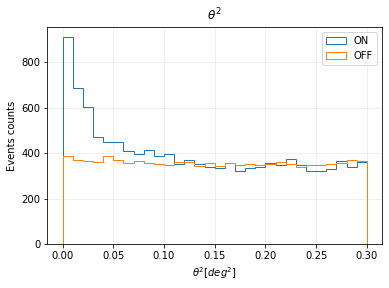

In [17]:
plt.hist(bins[:-1],bins=bins,histtype='step',weights=non_hist[0], label='ON')
plt.hist(bins[:-1],bins=bins,histtype='step',weights=ratio_on_off*noff_hist[0], label='OFF')
plt.title(r'$\theta^{2}$')
plt.grid(alpha=0.25)
plt.xlabel(r'$\theta^{2} [deg^{2}]$')
plt.ylabel('Events counts')
plt.legend()

# by uncommenting the following line you can save the plot once you created a folder named plots
# plt.savefig('../plots/theta2.pdf')

In [18]:
# you will decide where you want to cut the data
cut_theta2 = 0.04

In [19]:
def LiMa_significance(N_on, N_off, alpha):
    '''
    function to calculate how significant the excess of the on region 
    is compared to the off region, with
    N_on the total counts in ON region,
    N_off the total counts in off region,
    alpha the ratio of ON/OFF areas, in this case 1/5
    '''
    
    term1 = ( ( (1 + alpha) / alpha ) * (N_on / (N_on + N_off)) )
    term2 = (1 + alpha) * (N_off / (N_on + N_off))
    brakets = N_on * np.log(term1) + N_off * np.log(term2)
    
    return np.sqrt(2)*brakets**(1/2)

In [20]:
# select the bins that are below the cut in theta2
mask_theta2 = bins < cut_theta2

In [21]:
# summing the counts that survived the cut in theta2
N_on = np.sum(non_hist[0][mask_theta2[:-1]])
N_off = np.sum(noff_hist[0][mask_theta2[:-1]])

In [22]:
# calculating the significance
significance = LiMa_significance(N_on, N_off, ratio_on_off)
print(significance)

24.751572221016268


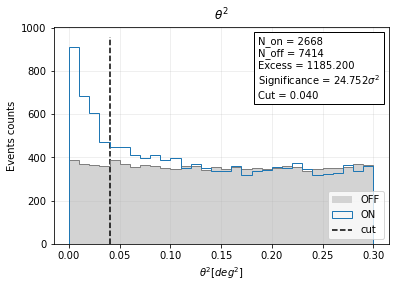

In [34]:
plt.hist(bins[:-1],bins=bins, histtype='stepfilled', color='lightgray', weights=ratio_on_off*noff_hist[0], label='OFF')
plt.hist(bins[:-1],bins=bins, histtype='step', color='gray', weights=ratio_on_off*noff_hist[0])
plt.hist(bins[:-1],bins=bins, histtype='step', weights=non_hist[0], label='ON')

plt.vlines(x=cut_theta2, ymin=plt.ylim()[0], ymax=plt.ylim()[1], ls='--', color='black', label="cut")
plt.title(r'$\theta^{2}$')
plt.grid(alpha=0.25)
plt.xlabel(r'$\theta^{2} [deg^{2}]$')
plt.ylabel('Events counts')
plt.legend(loc='lower right')

ax = plt.gca()
at0 = AnchoredText(
                f"N_on = {np.int(N_on)}\n"
                f"N_off = {np.int(N_off)}\n"
                f"Excess = {(N_on - N_off*1/5) :.3f}\n"
                f"Significance = {significance:.3f}"
                r"$\sigma^{2}$"
                f"\nCut = {cut_theta2:.3f}"
                , loc='upper right')
ax.add_artist(at0)

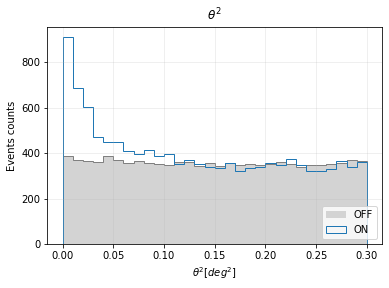

In [27]:
plt.hist(bins[:-1],bins=bins,histtype='stepfilled', color='lightgray', weights=ratio_on_off*noff_hist[0], label='OFF')
plt.hist(bins[:-1],bins=bins,histtype='step', color='gray', weights=ratio_on_off*noff_hist[0])
plt.hist(bins[:-1],bins=bins,histtype='step',weights=non_hist[0], label='ON')
plt.title(r'$\theta^{2}$')
plt.grid(alpha=0.25)
plt.xlabel(r'$\theta^{2} [deg^{2}]$')
plt.ylabel('Events counts')
plt.legend(loc='lower right')